# Recidivism

This notebook contains my analysis of data presented in 
"[Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)", Julia Angwin, Jeff Larson, Surya Mattu and Lauren Kirchner, ProPublica, May 23, 2016.

I would like to thank the authors of that article for making their data and analysis freely available.  They are a model of open science.


Copyright 2018 Allen Downey

The code and text of this notebook are under this license: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

The data are from [this repository](https://github.com/propublica/compas-analysis), which contains the data and analysis pipeline described on [this web page](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).

The terms of use for the data [are here](https://www.propublica.org/datastore/terms).  In compliance with those terms, I am not distributing the data, but there is a link below that downloads it directly.

In [1]:
%matplotlib inline
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
%precision 4

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sympy import symbols, Eq, solve

from overthink import decorate, crossings, interpolate

### Metrics

In this section I start with the [data reported here](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) and replicate the analysis there, computing various metrics based on the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix): prevalence, sensitivity, specificity, false positive rate, false negative rate, positive predictive value, and negative predictive value.

The following function takes an array and returns a Pandas DataFrame:

In [2]:
def make_matrix(a):
    """Make a confusion matrix from an array.
    
    a: array or list of lists
    
    returns: DataFrame
    """
    a = np.asarray(a).reshape((2, 2))
    index = ['Survived', 'Recidivated']
    columns = ['Low', 'High']
    return pd.DataFrame(a, index=index, columns=columns)

Make the matrix for all defendants.

In [3]:
a = [[2681, 1282], [1216, 2035]]
matrix_all = make_matrix(a)

,Low,High
Survived,2681,1282
Recidivated,1216,2035


Confirm that the total matches what's reported in the article.

In [4]:
np.sum(a)

7214

Compute sensitivity and specificity.

In [5]:
def percent(x, y):
    """Compute the percentage `x/(x+y)`.
    """
    return x / (x+y) * 100

def sens_spec(m):
    """Compute sensitivity and specificity.
    
    m: confusion matrix
    """
    tn, fp, fn, tp = m.values.flatten()
    sens = percent(tp, fn)
    spec = percent(tn, fp)
    return sens, spec

Compute sensitivity and specificity for all defendants.

In [6]:
sens, spec = sens_spec(matrix_all)
sens, spec

(62.59612426945556, 67.65076961897553)

Compute error rates.

In [7]:
def error_rates(m):
    """Compute false positive and false negative rate.
    
    m: confusion matrix
    """
    tn, fp, fn, tp = m.values.flatten()
    fpr = percent(fp, tn)
    fnr = percent(fn, tp)
    return fpr, fnr

Compute error rates for all defendants.

In [8]:
fpr, fnr = error_rates(matrix_all)
fpr, fnr

(32.349230381024476, 37.40387573054445)

Compute predictive value.

In [9]:
def predictive_value(m):
    """Compute positive and negatie predictive value.
    
    m: confusion matrix
    """
    tn, fp, fn, tp = m.values.flatten()
    ppv = percent(tp, fp)
    npv = percent(tn, fn)
    return ppv, npv

Compute predictive value for all defendants.

In [10]:
ppv, npv = predictive_value(matrix_all)
ppv, npv

(61.350618028338864, 68.79651013600206)

Compute prevalence.

In [11]:
def prevalence(df):
    """Compute prevalence.
    
    m: confusion matrix
    """
    tn, fp, fn, tp = df.values.flatten()
    prevalence = percent(tp+fn, tn+fp)
    return prevalence

Compute prevalences for all defendants.

In [12]:
prev = prevalence(matrix_all)
prev

45.06515109509287

Compute all metrics and put them in a DataFrame.

In [13]:
def compute_metrics(m, name=''):
    """Compute all metrics.
    
    m: confusion matrix
    
    returns: DataFrame
    """
    fpr, fnr = error_rates(m)
    ppv, npv = predictive_value(m)
    sens, spec = sens_spec(m)
    prev = prevalence(m)
    
    index = ['FP rate', 'FN rate', 'PPV', 'NPV',
             'Sensitivity', 'Specificity', 'Prevalence']
    df = pd.DataFrame(index=index, columns=['Percent'])
    df.Percent = fpr, fnr, ppv, npv, sens, spec, prev
    df.index.name = name
    return df

Compute metrics for all defendants.

In [14]:
compute_metrics(matrix_all, 'All defendants')

,Percent
All defendants,
FP rate,32.349230
FN rate,37.403876
PPV,61.350618
NPV,68.796510
Sensitivity,62.596124
Specificity,67.650770
Prevalence,45.065151


Make the confusion matrix for black defendants.

In [15]:
a = [[990, 805], [532, 1369]]
matrix_black = make_matrix(a)

,Low,High
Survived,990,805
Recidivated,532,1369


Compute metrics for black defendants.

In [16]:
black_metrics = compute_metrics(matrix_black, 'Black defendants')

,Percent
Black defendants,
FP rate,44.846797
FN rate,27.985271
PPV,62.971481
NPV,65.045992
Sensitivity,72.014729
Specificity,55.153203
Prevalence,51.433983


Make the confusion matrix for white defendants.

In [17]:
a = [[1139, 349], [461, 505]]
matrix_white = make_matrix(a)

,Low,High
Survived,1139,349
Recidivated,461,505


Compute metrics for white defendants.

In [18]:
white_metrics = compute_metrics(matrix_white, 'White defendants')

,Percent
White defendants,
FP rate,23.454301
FN rate,47.722567
PPV,59.133489
NPV,71.187500
Sensitivity,52.277433
Specificity,76.545699
Prevalence,39.364303


So far, all results are consistent with those reported in the article, including the headline results:

1. The false positive rate for black defendants is substantially higher than for white defendants (45%, compared to 23%).

2. The false negative rate for black defendants is substantially lower (28%, compared to 48%).

A false positive means that a defendant scored high on the test, was released, and did not recidivate within two years.

A false negative means that a defendant scored low on the test, was released, and recidivated within two years.

In [19]:
error_rates(matrix_black)

(44.84679665738162, 27.985270910047344)

In [20]:
error_rates(matrix_white)

(23.45430107526882, 47.72256728778468)

### The constant predictive value model

An ideal test should have equal predicitive value in all groups; that is, two people in the same risk category should have the same probability of recidivism, regardless of what group they are in.

And ideal test should also have the same error rates for all groups; that is, two non-recidivists should have the same probability of being classified as high risk. 

Unfortunately, these two goals are in conflict:

* If you design a test to achieve equal predictive value across groups with different prevalence, you will find that error rates depend on prevalence.  Speficially, false positive rates will be higher in groups with higher rates of recividism.

* If you design a test to achieve equal error rates across groups, you will find that predictive value depends on prevalence.  Specifically, positive predictive value will be lower in groups with lower rates of recidivism.

The next two sections demonstrate these effects.

A confusion matrix contains four values, but because they are contrained to add up to 100, it only takes 3 values to determine a confusion matrix.

For example, if you specify prevalence, PPV, and NPV, that determines a confusion matrix, and then you can compute the error rates.

Or, if you specify prevalence, FPR, and FNR, that determines a confusion matrix, and then you can compute predictive values.

The following function takes prevalence, PPV, and NPV and returns a confusion matrix.

In [21]:
def constant_predictive_value(prev, ppv, npv):
    """Make a confusion matrix with given metrics.
    
    prev: prevalence
    ppv: positive predictive value
    npv: negative predictive value
    
    returns: confusion matrix
    """
    tn, fp, fn, tp = symbols('tn fp fn tp')
    eq1 = Eq(percent(tp+fn, tn+fp), prev)
    eq2 = Eq(percent(tp, fp), ppv)
    eq3 = Eq(percent(tn,fn), npv)
    eq4 = Eq(tn+fp+fn+tp, 1)
    soln = solve([eq1, eq2, eq3, eq4], [tn, fp, fn, tp])
    a = list(soln.values())
    return make_matrix(a)

To test it, I'll construct a confusion matrix with the actual metrics from all defendents.

In [22]:
ppv, npv = predictive_value(matrix_all)
prev = prevalence(matrix_all)

m = constant_predictive_value(prev, ppv, npv)

,Low,High
Survived,0.371638480731910,0.177710008317161
Recidivated,0.168561131133906,0.282090379817023


If we use it to compute the other metrics, they are consistent with the results we got with the original data.

In [23]:
compute_metrics(m)

,Percent
,
FP rate,32.3492303810245
FN rate,37.4038757305443
PPV,61.3506180283389
NPV,68.7965101360021
Sensitivity,62.5961242694557
Specificity,67.6507696189755
Prevalence,45.0651510950929


We can use this function to run the "constant predictive value" model, which asks what happens if we keep PPV and NPV constant, and vary prevalence. 

In [24]:
ppv, npv = predictive_value(matrix_all)
prevalences = np.linspace(32, 60, 31)

fp_rates = pd.Series(index=prevalences)
fn_rates = pd.Series(index=prevalences)

for prev in prevalences:
    df = constant_predictive_value(prev, ppv, npv)
    fpr, fnr = error_rates(df)
    fp_rates[prev] = fpr
    fn_rates[prev] = fnr

The following figure shows the error rates we would expect from a test with equal predictive value for all groups, regardless of prevalence.

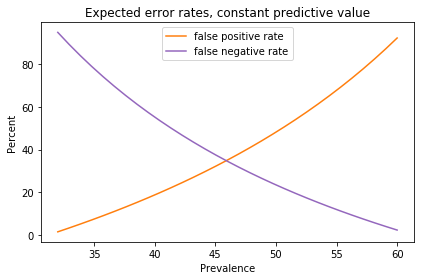

In [25]:
def plot_cpv_model():
    fp_rates.plot(label='false positive rate', color='C1')
    fn_rates.plot(label='false negative rate', color='C4')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Expected error rates, constant predictive value',
             loc='upper center')
    
plot_cpv_model()

As prevalence increases, false positive rates increase quickly.  Note the vertical scale: the difference in error rates between a low-prevalence group and a high-prevalence group is dramatic!

For the COMPAS test, the effect is not as extreme.  The following figure shows the constant prediction model again, including data points for the white defendants (left), all defendants (middle), and black defendants (right).

In [26]:
def plot_fpr_fnr(m):
    """Plot error rates versus prevalence.
    
    m: confusion matrix
    """
    prev = prevalence(m)
    fpr, fnr = error_rates(m)
    plt.plot(prev, fpr, 'o', color='C1')
    plt.plot(prev, fnr, 'o', color='C4')

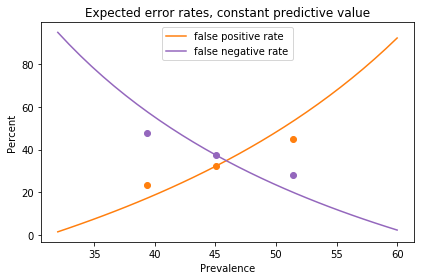

In [27]:
plot_fpr_fnr(matrix_all)
plot_fpr_fnr(matrix_black)
plot_fpr_fnr(matrix_white)

plot_cpv_model()

For black defendants:

* The actual false positive rate is lower that what we would expect if the test had the same predictive value for all groups.

* The actual false negative rate is higher than expected.

For white defendants:

* The actual false positive rate is higher than what we would expect if the test had the same predictive value for all groups.

* The actual false negative rate is lower than expected.

Relative to the CPV model, the COMPAS test is what I will call "tempered"; that is, it is less sensitive to variation in prevalence between groups.


### Constant error rate model

In the previous section we held predictive value constant and computed the effect on error rates.  In this section we'll go the other way: if we hold error rates constant for all groups, what effect does that have on predictive value?

The following function takes prevalence and error rates and returns a confusion matrix.



In [28]:
def constant_error_rates(prev, fpr, fnr):
    """Make a confusion matrix with given metrics.
    
    prev: prevalence
    fpr: false positive rate
    fnr: false negative rate
    
    returns: confusion matrix
    """
    tn, fp, fn, tp = symbols('tn fp fn tp')
    eq1 = Eq(percent(tp+fn, tn+fp), prev)
    eq2 = Eq(percent(fp, tn), fpr)
    eq3 = Eq(percent(fn, tp), fnr)
    eq4 = Eq(tn+fp+fn+tp, 1)
    soln = solve([eq1, eq2, eq3, eq4], [tn, fp, fn, tp])
    a = list(soln.values())
    return make_matrix(a)

Again, just to test it, we can replicate the observed confusion matrix.

In [29]:
fpr, fnr = error_rates(matrix_all)
prev = prevalence(matrix_all)
m = constant_error_rates(prev, fpr, fnr)

,Low,High
Survived,0.371638480731910,0.177710008317161
Recidivated,0.168561131133907,0.282090379817022


And it has the right metrics

In [30]:
compute_metrics(m)

,Percent
,
FP rate,32.3492303810245
FN rate,37.4038757305445
PPV,61.3506180283388
NPV,68.7965101360020
Sensitivity,62.5961242694555
Specificity,67.6507696189755
Prevalence,45.0651510950929


Now we can see how predictive value depends on prevalence (with error rates held constant).

In [31]:
fpr, fnr = error_rates(matrix_all)
prevalences = np.linspace(20, 70, 31)

ppv_rates = pd.Series(index=prevalences)
npv_rates = pd.Series(index=prevalences)

for prev in prevalences:
    df = constant_error_rates(prev, fpr, fnr)
    ppv, npv = predictive_value(df)
    ppv_rates[prev] = ppv
    npv_rates[prev] = npv

The following function plots the results.

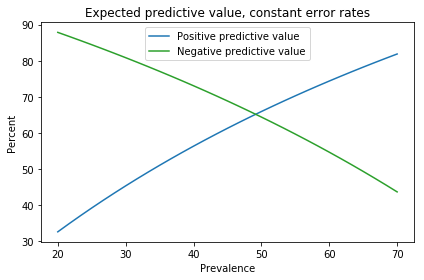

In [32]:
def plot_cer_model():
    ppv_rates.plot(label='Positive predictive value', color='C0')
    npv_rates.plot(label='Negative predictive value', color='C2')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Expected predictive value, constant error rates',
             loc='upper center')
    
plot_cer_model()

As prevalence increases, so does positive predictive value.

For the COMPAS test, the effect is not as extreme.  The following figure shows the constant error rate again, including data points for the white defendants (left), all defendants (middle), and black defendants (right).

In [120]:
def plot_ppv_npv(m):
    """Plot predictive values versus prevalence.
    
    m: confusion matrix
    """
    prev = prevalence(m)
    ppv, npv = predictive_value(m)
    plt.plot(prev, ppv, 'o', color='C0')
    plt.plot(prev, npv, 'o', color='C2')

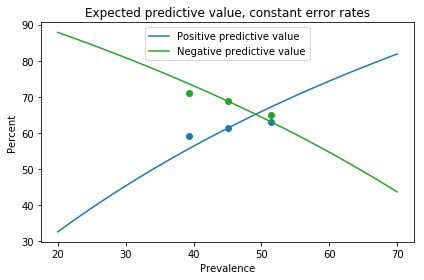

In [121]:
plot_ppv_npv(matrix_all)
plot_ppv_npv(matrix_black)
plot_ppv_npv(matrix_white)

plot_cer_model()

Again, the test is less sensitive to differences in prevalence between groups than we would expect from the constant error rate model.

### More data, more details

In this section I read the detailed dataset available from [this repository](https://github.com/propublica/compas-analysis) and run a bunch of validation checks.

In [119]:
# Uncomment and run this cell once to download the data.
# Then comment it again so you don't download it every time you run the notebook.
# !wget 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'

In [118]:
cp = pd.read_csv("compas-scores-two-years.csv")
cp.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [36]:
cp.shape

(7214, 53)

In [37]:
for col in cp.columns:
    print(col)

id
name
first
last
compas_screening_date
sex
dob
age
age_cat
race
juv_fel_count
decile_score
juv_misd_count
juv_other_count
priors_count
days_b_screening_arrest
c_jail_in
c_jail_out
c_case_number
c_offense_date
c_arrest_date
c_days_from_compas
c_charge_degree
c_charge_desc
is_recid
r_case_number
r_charge_degree
r_days_from_arrest
r_offense_date
r_charge_desc
r_jail_in
r_jail_out
violent_recid
is_violent_recid
vr_case_number
vr_charge_degree
vr_offense_date
vr_charge_desc
type_of_assessment
decile_score.1
score_text
screening_date
v_type_of_assessment
v_decile_score
v_score_text
v_screening_date
in_custody
out_custody
priors_count.1
start
end
event
two_year_recid


The following functions compute value counts and percentages for various variables.

In [38]:
def make_dataframe(series, *columns):
    """Make a Series into a DataFrame with one column.
    
    So it looks better in Jupyter.
    
    series: Series
    columns: column name(s)
    
    returns: DataFrame
    """
    df = pd.DataFrame(series.values,
                      index=series.index,
                      columns=columns)
    df.index.name = series.name
    return df

def counts(df, var):
    """Compute counts for each unique value.
    
    df: DataFrame
    var: variable name
    """
    series = df[var].value_counts()
    return make_dataframe(series, 'Count')

def percentages(df, var):
    """Compute percentages for each unique value.
    
    df: DataFrame
    var: variable name
    """
    series = df[var].value_counts() / len(df) * 100
    return make_dataframe(series, 'Percentage')

Breakdown by age

In [39]:
counts(cp, 'age_cat')

,Count
age_cat,
25 - 45,4109
Greater than 45,1576
Less than 25,1529


In [40]:
percentages(cp, 'age_cat')

,Percentage
age_cat,
25 - 45,56.958691
Greater than 45,21.846410
Less than 25,21.194899


Breakdown by race

In [41]:
counts(cp, 'race')

,Count
race,
African-American,3696
Caucasian,2454
Hispanic,637
Other,377
Asian,32
Native American,18


In [42]:
percentages(cp, 'race')

,Percentage
race,
African-American,51.233712
Caucasian,34.017189
Hispanic,8.830053
Other,5.225950
Asian,0.443582
Native American,0.249515


Breakdown by sex

In [43]:
counts(cp, 'sex')

,Count
sex,
Male,5819
Female,1395


In [44]:
percentages(cp, 'sex')

,Percentage
sex,
Male,80.6626
Female,19.3374


Breakdown by recidivism

In [45]:
counts(cp, 'two_year_recid')

,Count
two_year_recid,
0,3963
1,3251


In [46]:
percentages(cp, 'two_year_recid')

,Percentage
two_year_recid,
0,54.934849
1,45.065151


Breakdown by risk category

In [47]:
counts(cp, 'score_text')

,Count
score_text,
Low,3897
Medium,1914
High,1403


In [48]:
percentages(cp, 'score_text')

,Percentage
score_text,
Low,54.019961
Medium,26.531744
High,19.448295


The following function computes cross-tabulations.

In [49]:
def crosstab(df, index, columns):
    """Compute a cross-tabulation.
    
    df: DataFrame
    index: variable(s) that will label the rows
    columns: variable(s) that will label the columns
    
    returns: DataFrame
    """

    xtab = df.pivot_table(index=index, 
                          columns=columns,
                          values='id',
                          aggfunc='count')
    
    return xtab

Breakdown by sex and race

In [50]:
xtab = crosstab(cp, 'sex', 'race')

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,652,2,567,103,4,67
Male,3044,30,1887,534,14,310


Breakdown by age and race

In [51]:
xtab = crosstab(cp, 'age_cat', 'race')

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
age_cat,,,,,,
25 - 45,2194,14,1312,367,12,210
Greater than 45,582,11,752,143,3,85
Less than 25,920,7,390,127,3,82


Breakdown by age and sex

In [52]:
xtab = crosstab(cp, 'age_cat', 'sex')

sex,Female,Male
age_cat,,
25 - 45,807,3302
Greater than 45,300,1276
Less than 25,288,1241


Distribution of decile scores for black defendants.

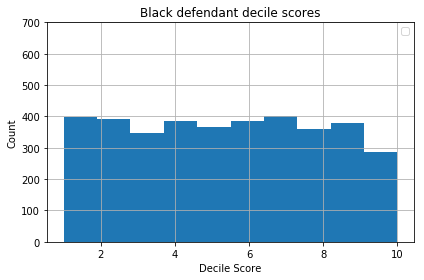

In [53]:
cp.loc[cp.race=='African-American', 'decile_score'].hist()
decorate(xlabel='Decile Score',
         ylabel='Count',
         title='Black defendant decile scores',
         ylim=[0, 700])

Distribution of decile scores for white defendants.

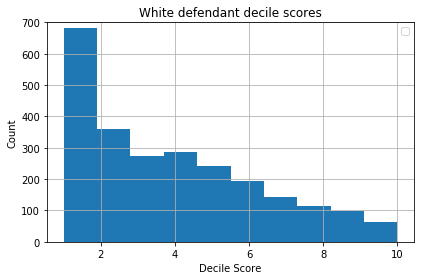

In [54]:
cp.loc[cp.race=='Caucasian', 'decile_score'].hist()
decorate(xlabel='Decile Score',
         ylabel='Count',
         title='White defendant decile scores',
         ylim=[0, 700])

Cross tabulation of decile score and race.

In [55]:
crosstab(cp, 'decile_score', 'race')

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,398.0,15.0,681.0,196.0,NaN,150.0
2,393.0,4.0,361.0,113.0,4.0,66.0
3,346.0,5.0,273.0,86.0,1.0,36.0
4,385.0,NaN,285.0,52.0,1.0,46.0
5,365.0,1.0,241.0,52.0,NaN,22.0
6,384.0,3.0,194.0,37.0,2.0,21.0
7,400.0,1.0,143.0,34.0,4.0,10.0
8,359.0,2.0,114.0,26.0,1.0,10.0
9,380.0,NaN,98.0,20.0,2.0,8.0


Cross tabulation of decile score and age group.

In [56]:
crosstab(cp, 'decile_score', 'age_cat')

age_cat,25 - 45,Greater than 45,Less than 25
decile_score,,,
1,654,782,4
2,660,182,99
3,437,120,190
4,434,98,237
5,405,85,191
6,357,104,180
7,340,77,175
8,298,57,157
9,292,54,162


Here's the confusion matrix with all three score categories.

In [57]:
crosstab(cp, 'two_year_recid', 'score_text')

score_text,High,Low,Medium
two_year_recid,,,
0,402,2681,880
1,1001,1216,1034


To make sure I've got the data right, I'll reproduce the confusion matrices from the article.

In [58]:
def compute_matrix(df):
    """Compute a confusion matrix from data.
    
    df: DataFrame
    
    returns: confusion matrix
    """
    high = cp.score_text.isin(['Medium', 'High']).astype(int)
    return crosstab(df, 'two_year_recid', high)

All defendants.

In [59]:
compute_matrix(cp)

score_text,0,1
two_year_recid,,
0,2681,1282
1,1216,2035


And the differences are 0.

In [60]:
matrix_all - compute_matrix(cp).values

,Low,High
Survived,0,0
Recidivated,0,0


Black defendants.

In [61]:
black = cp[cp.race=='African-American']
compute_matrix(black)

score_text,0,1
two_year_recid,,
0,990,805
1,532,1369


In [62]:
matrix_black - compute_matrix(black).values

,Low,High
Survived,0,0
Recidivated,0,0


White defendants.

In [63]:
white = cp[cp.race=='Caucasian']
compute_matrix(white)

score_text,0,1
two_year_recid,,
0,1139,349
1,461,505


In [64]:
matrix_white - compute_matrix(white).values

,Low,High
Survived,0,0
Recidivated,0,0


### Calibration

To check for calibration, I group defendents by decile score and compute prevalence (recidivism rate) in each group.

This analysis does not take observation time into account, unlike the analysis in the original article.

The following function groups defendants by decile score and computes prevalence in each group.

In [65]:
def prob_recid(df):
    """Compute probability of recidivism by decile score.
    
    df: DataFrame
    
    returns: Series
    """
    return df.groupby('decile_score').two_year_recid.mean()

The following figure shows this calibration curve for all defendants and broken down by race.

In [66]:
def plot_calibration(df, group_vars, title=''):
    prob_recid(cp).plot(linestyle='dotted',
                        label='All defendants', color='gray')

    for name, group in cp.groupby(group_vars):
        if len(group) > 1000:
            prob_recid(group).plot(label=name)

    decorate(xlabel='Decile score',
             ylabel='Prob recidivism',
             title=title)

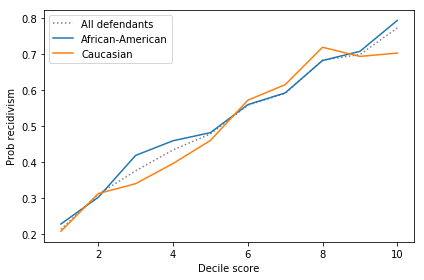

In [67]:
plot_calibration(cp, 'race')

The test is well calibrated.  People with higher scores have higher probabilities of recidivism.  In fact, we could use this curve to transform COMPAS scores into probabilities.

The test is about equally calibrated for black and white defendants, although black defendants with scores 3 and 4 are more likely to recidivate than white defendants with the same scores.

Here's the breakdown by age group.

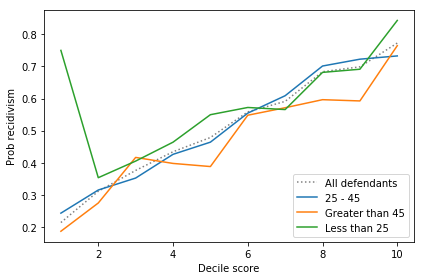

In [68]:
plot_calibration(cp, 'age_cat')

The test is about equally calibrated for all age groups, which means that people with the same score have about the same probability of recidivism, regardless of what group they are in.

There are only 4 people in the "Less than 25" group with decile score 1, which is why that data point is so out of line.

Here's the breakdown by sex.

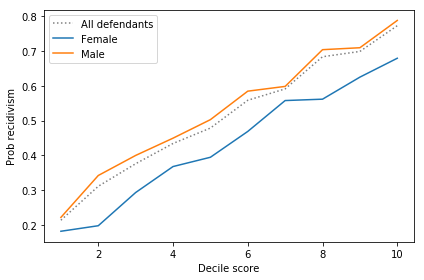

In [69]:
plot_calibration(cp, 'sex')

Here's the first case where the test does not seem well calibrated.  At all decile scores, female defendants are substantially less likely to recidivate than male defendants.

In [70]:
subset = cp[cp.race.isin(['African-American', 'Caucasian'])]
subset.shape

(6150, 53)

### Comparing reality to the CPV model

In this section I'll compare actual PPV and FPR for a variety of subgroups to the values we would expect based on the CPV model; that is, a model where the predictive values are the same for all groups.

The following function groups defendants by `group_vars` and returns a table with one row for each group.

In [71]:
def make_table(df, group_vars, expected_ppv, expected_npv):
    """Make a table with one line per group.
    
    df: DataFrame
    group_vars: string or list of string variable names
    expected_ppv: 
    expected_npv:
    
    returns: table
    """
    # make the DataFrame
    columns = ['count', 'prevalence',
               'actual PPV', 'actual NPV', 'actual FNR',
               'expected FPR', 'actual FPR', 'difference']
    columns = group_vars + columns 

    table = pd.DataFrame(columns=columns)

    # loop through the groups
    grouped = subset.groupby(group_vars)
    for i, (name, group) in enumerate(grouped):
        if not isinstance(name, tuple):
            name = name,
        
        # size of group
        count = len(group)
        
        # compute metrics
        matrix = compute_matrix(group)
        prev = prevalence(matrix)
        actual_ppv, actual_npv = predictive_value(matrix)
        actual_fpr, actual_fnr = error_rates(matrix)

        # generate the CPV matrix
        cpv = constant_predictive_value(prev, 
                          expected_ppv, expected_npv)

        # get the expected error rates
        expected_fpr, _ = error_rates(cpv * 100)
        
        # for very low and high prevalences, it might
        # not be possible to achieve given predictive values
        if expected_fpr < 0:
            expected_fpr = 0

        if expected_fpr > 100:
            expected_fpr = 100

        # difference between actual and expected
        diff = actual_fpr - expected_fpr

        # add a row to the table
        row = name + (count, prev,
                      actual_ppv, actual_npv, actual_fnr,
                      expected_fpr, actual_fpr, diff)
        
        table.loc[i] = row
        
    # sort the table by prevalence
    table.sort_values(by='prevalence', inplace=True)
    return table

Here's the breakdown by age category.

In [72]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat']
table1 = make_table(subset, group_vars, ppv, npv)

,age_cat,count,prevalence,actual PPV,actual NPV,actual FNR,expected FPR,actual FPR,difference
1,Greater than 45,1334,32.908546,54.945055,75.360825,54.441913,3.25812703191668,18.324022,15.0658953144520
0,25 - 45,3506,47.803765,61.931499,66.782609,34.188544,40.7730043881377,37.049180,-3.72382406026880
2,Less than 25,1310,57.404580,64.665912,57.611241,24.069149,78.8593270762673,55.913978,-22.9453485816437


Again, the actual behavior of the test is tempered, compare to the CPV model; that is, the results are less extreme than the model expects.

Here's the breakdown by race.

In [73]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['race']
table2 = make_table(subset, group_vars, ppv, npv)

,race,count,prevalence,actual PPV,actual NPV,actual FNR,expected FPR,actual FPR,difference
1,Caucasian,2454,39.364303,59.133489,71.187500,47.722567,17.2544721036439,23.454301,6.19982897162488
0,African-American,3696,51.433983,62.971481,65.045992,27.985271,53.4036054274053,44.846797,-8.55680877002365


The false positive rate for whites is higher than we would expect if predictive value were the same for all groups.

The false positive rate for blacks is lower than we would expect.

Here's the breakdown by sex.

In [74]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['sex']
table3 = make_table(subset, group_vars, ppv, npv)

,sex,count,prevalence,actual PPV,actual NPV,actual FNR,expected FPR,actual FPR,difference
0,Female,1219,36.587367,50.980392,75.683891,35.874439,10.8846867203845,35.575679,24.6909924516724
1,Male,4931,49.097546,64.369680,66.193182,34.407270,45.0678340229313,35.019920,-10.0479137042062


The false positive rate for women is substantially higher than what we would expect in the CPV model, which is consistent with the calibration results in the previous section.

Here's the breakdown by age and race.

In [75]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat', 'race']
table4 = make_table(subset, group_vars, ppv, npv)

,age_cat,race,count,prevalence,actual PPV,actual NPV,actual FNR,expected FPR,actual FPR,difference
3,Greater than 45,Caucasian,752,27.792553,55.555556,77.322835,68.899522,0,9.576427,9.57643
2,Greater than 45,African-American,582,39.518900,54.655870,71.641791,41.304348,17.6262781850286,31.818182,14.1919036331532
1,25 - 45,Caucasian,1312,43.140244,60.000000,67.241379,46.996466,26.9139758955996,26.809651,-0.104324421068796
5,Less than 25,Caucasian,390,48.974359,59.071730,66.666667,26.701571,44.6495211038666,48.743719,4.09419748909818
0,25 - 45,African-American,2194,50.592525,62.685402,66.374589,27.657658,50.3106752879841,44.095941,-6.21473432857449
4,Less than 25,African-American,920,60.978261,66.718266,52.554745,23.172906,97.8224228659821,59.888579,-37.9338434787955


Breakdown by age and sex.

In [76]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat', 'sex']
table5 = make_table(subset, group_vars, ppv, npv)

,age_cat,sex,count,prevalence,actual PPV,actual NPV,actual FNR,expected FPR,actual FPR,difference
2,Greater than 45,Female,259,23.552124,41.071429,81.280788,62.295082,0,16.666667,16.6667
3,Greater than 45,Male,1075,35.162791,57.467532,73.794003,53.174603,7.82872060272464,18.794835,10.9661144044490
0,25 - 45,Female,704,40.056818,55.520505,72.609819,37.588652,18.9349160741967,33.412322,14.4774062006848
4,Less than 25,Female,256,40.234375,46.276596,76.470588,15.533981,19.3720445626131,66.013072,46.6410273328117
1,25 - 45,Male,2802,49.750178,63.319672,65.097160,33.500717,47.3182268799581,38.139205,-9.17902233450359
5,Less than 25,Male,1054,61.574953,69.640288,54.038997,25.423729,100,52.098765,-47.9012


Breakdown by race and sex.

In [77]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['race', 'sex']
table6 = make_table(subset, group_vars, ppv, npv)

,race,sex,count,prevalence,actual PPV,actual NPV,actual FNR,expected FPR,actual FPR,difference
2,Caucasian,Female,567,35.097002,50.446429,74.927114,43.216080,7.69083250175007,30.163043,22.4722109765108
0,African-American,Female,652,37.883436,51.335312,76.507937,29.959514,13.7867567264522,40.493827,26.7070704340416
3,Caucasian,Male,1887,40.646529,62.222222,70.167064,48.891786,20.3968108299805,21.250000,0.853189170019501
1,African-American,Male,3044,54.336399,65.106151,62.054681,27.690447,64.9466440776828,46.115108,-18.8315361640137


Breakdown by age, race, and sex.

In [78]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat', 'race', 'sex']
table7 = make_table(subset, group_vars, ppv, npv)

,age_cat,race,sex,count,prevalence,actual PPV,actual NPV,actual FNR,expected FPR,actual FPR,difference
4,Greater than 45,African-American,Female,88,22.727273,44.827586,88.135593,35.000000,0,23.529412,23.5294
6,Greater than 45,Caucasian,Female,171,23.976608,37.037037,78.472222,75.609756,0,13.076923,13.0769
7,Greater than 45,Caucasian,Male,581,28.915663,61.111111,76.985743,67.261905,0,8.474576,8.47458
10,Less than 25,Caucasian,Female,87,31.034483,38.235294,94.736842,3.703704,0,70.000000,70
0,25 - 45,African-American,Female,395,38.227848,52.659574,74.879227,34.437086,14.5784223461080,36.475410,21.8969874899576
2,25 - 45,Caucasian,Female,309,42.394822,59.689922,70.000000,41.221374,24.9067389374193,29.213483,4.30674420864812
5,Greater than 45,African-American,Male,494,42.510121,55.963303,68.115942,41.904762,25.2138089028154,33.802817,8.58900799859303
3,25 - 45,Caucasian,Male,1003,43.369890,60.107817,66.455696,48.735632,27.5430043789732,26.056338,-1.48666635080423
8,Less than 25,African-American,Female,169,44.970414,50.833333,69.387755,19.736842,32.0728304197014,63.440860,31.3680297953524
1,25 - 45,African-American,Male,1799,53.307393,64.409881,63.881020,26.590198,60.6900439996716,46.309524,-14.3805201901478


Those are all the possible subgroups for these three variables.

Now we can see what the results look like.

In [79]:
tables = [table1, table2, table3, table4, table5, table6, table7];

The following function plots one data point per subgroup showing the given metric versus prevalence.

Groups with a small number of people are shown with lighter colors.


In [80]:
def plot_table_var(table, var, color):
    """Plot one data point per row.
    
    table: DataFrame
    var: which metric to plot
    color: string
    """
    for _, row in table.iterrows():
        alpha = 0.8 if row['count'] > 200 else 0.3

        plt.plot(row['prevalence'], row[var],
                 'o', color=color, alpha=alpha)

Here's what the results look like for FPR.

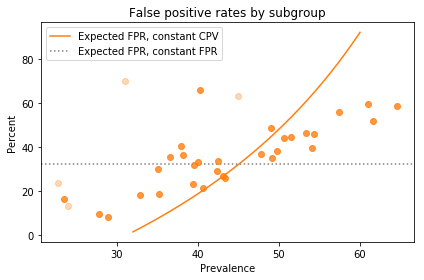

In [81]:
fp_rates.plot(label='Expected FPR, constant CPV',
              color='C1')
plt.axhline(fpr, linestyle='dotted', 
            label='Expected FPR, constant FPR', color='gray')

for table in tables:
    plot_table_var(table, 'actual FPR', 'C1')
    
decorate(xlabel='Prevalence',
         ylabel='Percent',
         title='False positive rates by subgroup')

In general, groups with higher prevalence have higher false positive rates, but the effect is less extreme than what we would expect from the CPV model.

Here are the results for positive predictive value.

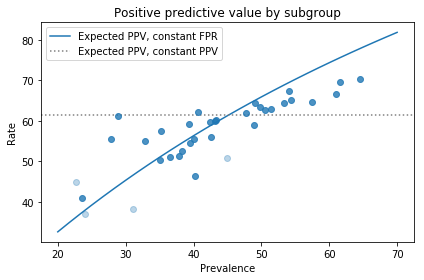

In [82]:
ppv_rates.plot(label='Expected PPV, constant FPR', color='C0')
plt.axhline(ppv, linestyle='dotted', 
            label='Expected PPV, constant PPV', color='gray')

for table in tables:
    plot_table_var(table, 'actual PPV', 'C0')
    
decorate(xlabel='Prevalence',
         ylabel='Rate',
         title='Positive predictive value by subgroup')

Groups with higher prevalence have higher PPV, but the effect is less extreme than we would expect from the CPV model.

Here are the results for false negative rate.

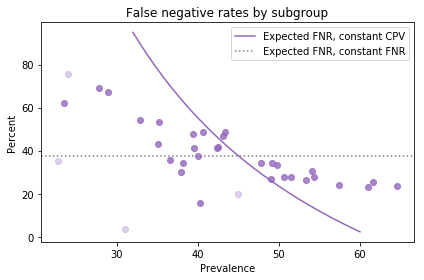

In [83]:
fn_rates.plot(label='Expected FNR, constant CPV',
              color='C4')
plt.axhline(fnr, linestyle='dotted', 
            label='Expected FNR, constant FNR', color='gray')

for table in tables:
    plot_table_var(table, 'actual FNR', 'C4')
    
decorate(xlabel='Prevalence',
         ylabel='Percent',
         title='False negative rates by subgroup')

Groups with higher prevalence have lower FNR, but the effect is less extreme than we would expect from the CPV model.

Here are the results for negative predictive value.

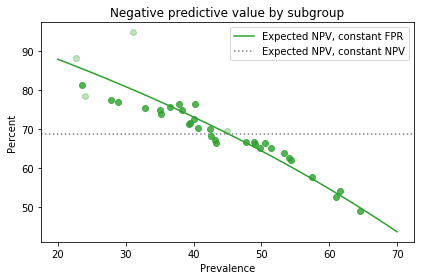

In [84]:
npv_rates.plot(label='Expected NPV, constant FPR', color='C2')
plt.axhline(npv, linestyle='dotted', 
            label='Expected NPV, constant NPV', color='gray')

for table in tables:
    plot_table_var(table, 'actual NPV', 'C2')
    
decorate(xlabel='Prevalence',
         ylabel='Percent',
         title='Negative predictive value by subgroup')

Groups with higher prevalence have lower NPV.  In this case, the effect is almost exactly what we would expect from the CPV model.

### What would it take?

In this section I explore what it would take to make a test with the same false positive rate for all groups.

In [85]:
def fpr_thresh(df, thresh):
    df = df.copy()
    df['high'] = df.decile_score >= thresh
    matrix_all = crosstab(df, 'two_year_recid', 'high')
    fpr, fnr = error_rates(matrix_all)
    return fpr

In [86]:
fpr_thresh(cp, 5)

32.349230381024476

In [87]:
fpr_thresh(black, 5)

44.84679665738162

In [88]:
fpr_thresh(white, 5)

23.45430107526882

In [89]:
def sweep_thresh(df):
    threshes = range(2,10)
    sweep = pd.Series(index=threshes)
    for thresh in threshes:
        sweep[thresh] = fpr_thresh(df, thresh)
        
    return sweep

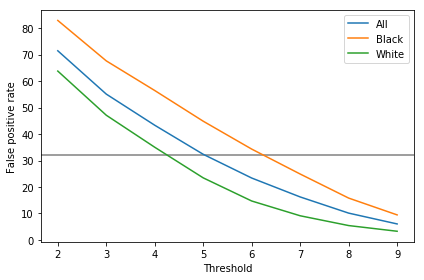

In [90]:
plt.axhline(32.25, color='gray')
sweep_thresh(cp).plot(label='All')
sweep_thresh(black).plot(label='Black')
sweep_thresh(white).plot(label='White')
decorate(xlabel='Threshold',
         ylabel='False positive rate')

In [91]:
def find_threshold(group, fpr):
    series = sweep_thresh(group)
    xs = crossings(series.dropna(), fpr)
    return xs

In [92]:
all_thresh = find_threshold(cp, 32.35)

array([4.9999])

In [93]:
black_thresh = find_threshold(black, 32.35)

array([6.2038])

In [94]:
white_thresh = find_threshold(white, 32.35)

array([4.2247])

In [95]:
interpolate(prob_recid(cp), all_thresh)

array([0.4787])

In [96]:
interpolate(prob_recid(cp), black_thresh)

array([0.5664])

In [97]:
interpolate(prob_recid(black), black_thresh)

array([0.5681])

In [98]:
interpolate(prob_recid(cp), white_thresh)

array([0.4432])

In [99]:
interpolate(prob_recid(white), white_thresh)

array([0.4083])

In [100]:
black_male = black[black.sex=='Male']
black_male.shape

(3044, 53)

In [101]:
black_female = black[black.sex=='Female']
black_female.shape

(652, 53)

In [102]:
old_black_female = black_female[black_female.age_cat=='Greater than 45']
old_black_female.shape

(88, 53)

In [103]:
old_white_female = cp[(cp.age_cat=='Greater than 45') &
                      (cp.sex=='Female') &
                      (cp.race=='Caucasian')]
old_white_female.shape

(171, 53)

In [104]:
young_black_male = cp[(cp.age_cat=='Less than 25') &
                      (cp.sex=='Male') &
                      (cp.race=='African-American')]
young_black_male.shape

(751, 53)

In [105]:
fpr_thresh(cp, 5)

32.349230381024476

In [106]:
fpr_thresh(black, 5)

44.84679665738162

In [107]:
fpr_thresh(black_female, 5)

40.49382716049383

In [108]:
fpr_thresh(old_black_female, 5)

23.52941176470588

In [109]:
fpr_thresh(black_male, 5)

46.115107913669064

In [110]:
fpr_thresh(young_black_male, 5)

58.64661654135338

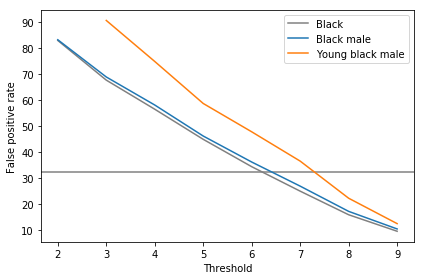

In [111]:
plt.axhline(32.25, color='gray')
sweep_thresh(black).plot(label='Black', color='gray')
sweep_thresh(black_male).plot(label='Black male')
sweep_thresh(young_black_male).plot(label='Young black male')

decorate(xlabel='Threshold',
         ylabel='False positive rate')

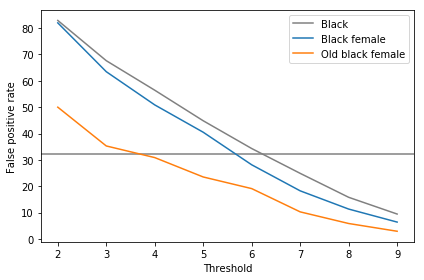

In [112]:
plt.axhline(32.25, color='gray')
sweep_thresh(black).plot(label='Black', color='gray')
sweep_thresh(black_female).plot(label='Black female')
sweep_thresh(old_black_female).plot(label='Old black female')

decorate(xlabel='Threshold',
         ylabel='False positive rate')

In [113]:
ybm_thresh = find_threshold(young_black_male, 32.35)

array([7.2959])

In [114]:
obf_thresh = find_threshold(old_black_female, 32.35)

array([3.6859])

In [115]:
interpolate(prob_recid(cp), ybm_thresh)

array([0.6164])

In [116]:
interpolate(prob_recid(cp), obf_thresh)

array([0.4185])